In [1]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')


In [2]:
import numpy as np
import streamlit as st
from copy import deepcopy as dc
import pandas as pd
from pathlib import Path
from src.label_checker_automata import LabelCheckerAutomata
from src.caption import Caption
import src.utils as utils

## Load data and all labels

In [3]:
data_dir = Path("../data/new/images")

labels = []

for image_fn in data_dir.iterdir():
    if image_fn.suffix == ".jpg" and not image_fn.name.startswith("."):
        labels.append("_".join(image_fn.stem.split("_")[1:]))

df = pd.DataFrame.from_dict({
    "label": labels,
})
df

,label
0,G A cross
1,A G cross patonce
2,O S lion rampant
3,S A eagle
4,"lion; maunch fisted holding annulet, crusily;..."
...,...
577,3 lion's heads cr; per chevron & 3 wings fess...
578,G O 2 lions passt guard
579,B A cross engrailed
580,O G lion q.f. cr.


# Duplicates in labels: Histogram of labels

In [4]:
def plot_bar_chart(data):
    labels, values = zip(*data)
    indexes = np.arange(len(labels))
    width = 0.5

    plt.rcParams["figure.figsize"] = (20, 10)
    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels, rotation='vertical', fontsize=15)
    plt.show()


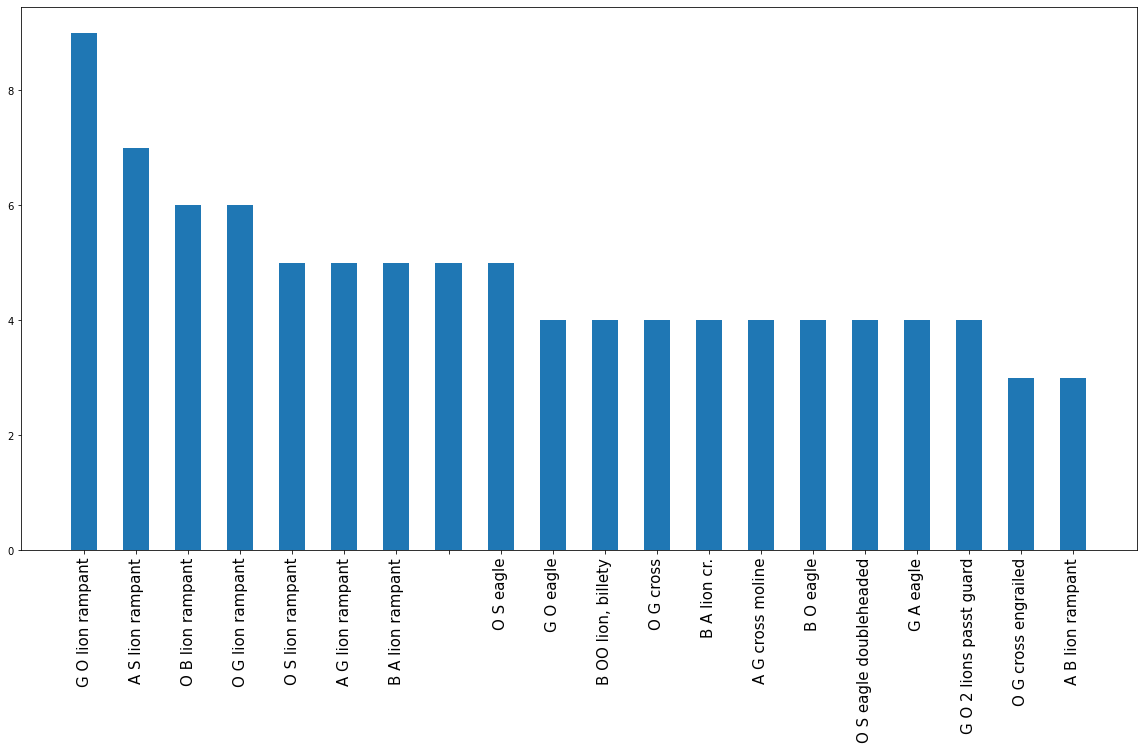

453

In [5]:
import matplotlib.pyplot as plt
from collections import Counter

x = Counter(labels)
plot_bar_chart(x.most_common(20))
# x.most_common(20)
len(x)

In [6]:
elems, count = np.unique(labels, return_counts=True)
output = []
counter=0
for l, n in zip(elems, count):
    if n > 1:
        print(f'{n} : "{l}"')
        counter+=1


5 : ""
2 : " 3 fleurs-de-lis; 3 lions passt guard; =; = :: book  {BO, GO; A}"
2 : " castle; lion; =; =  {GO, AP}"
2 : "A B lion cr."
3 : "A B lion rampant"
2 : "A G 3 eagles"
2 : "A G 3 lions"
3 : "A G cross"
4 : "A G cross moline"
3 : "A G eagle"
2 : "A G eagle doubleheaded"
3 : "A G lion cr."
2 : "A G lion q.f. cr."
5 : "A G lion rampant"
2 : "A GO cross ch. 5 escallops"
2 : "A GOS per pale eagle isst & barry"
2 : "A S 2 lions passt guard"
2 : "A S cross"
2 : "A S eagle"
2 : "A S lion cr."
7 : "A S lion rampant"
2 : "A V lion rampant"
2 : "B A cross"
4 : "B A lion cr."
5 : "B A lion rampant"
2 : "B O 3 eagles"
4 : "B O eagle"
2 : "B O eagle cr."
2 : "B O lion cr."
3 : "B O lion rampant"
4 : "B OO lion, billety"
2 : "G A 3 lions"
2 : "G A cross"
4 : "G A eagle"
2 : "G A eagle cr."
2 : "G A eagle doubleheaded"
2 : "G A lion rampant"
2 : "G AA lion, billety"
2 : "G E lion rampant"
4 : "G O 2 lions passt guard"
4 : "G O eagle"
2 : "G O eagle doubleheaded"
2 : "G O lion cr."
9 : "G O lion

In [7]:
count.sum()

582

In [8]:
print(f'There are {counter} repeated labels out of {len(elems)} total labels')

There are 67 repeated labels out of 453 total labels


In [9]:
import re

voc = []
for label in labels:
    ws = re.findall(r'\w+', label)
    for w in ws:
        voc.append(w)
len(voc), len(set(voc))

(3351, 323)

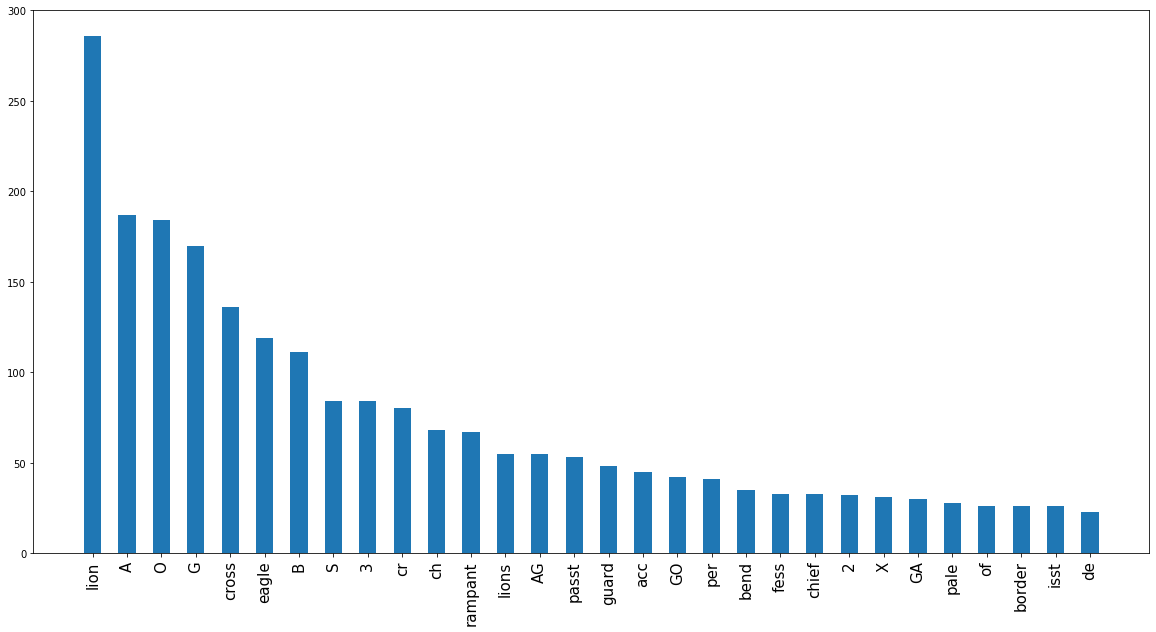

[('lion', 286),
 ('A', 187),
 ('O', 184),
 ('G', 170),
 ('cross', 136),
 ('eagle', 119),
 ('B', 111),
 ('S', 84),
 ('3', 84),
 ('cr', 80),
 ('ch', 68),
 ('rampant', 67),
 ('lions', 55),
 ('AG', 55),
 ('passt', 53),
 ('guard', 48),
 ('acc', 45),
 ('GO', 42),
 ('per', 41),
 ('bend', 35),
 ('fess', 33),
 ('chief', 33),
 ('2', 32),
 ('X', 31),
 ('GA', 30),
 ('pale', 28),
 ('of', 26),
 ('border', 26),
 ('isst', 26),
 ('de', 23)]

In [10]:

y = Counter(voc)
plot_bar_chart(y.most_common(30))
y.most_common(30)

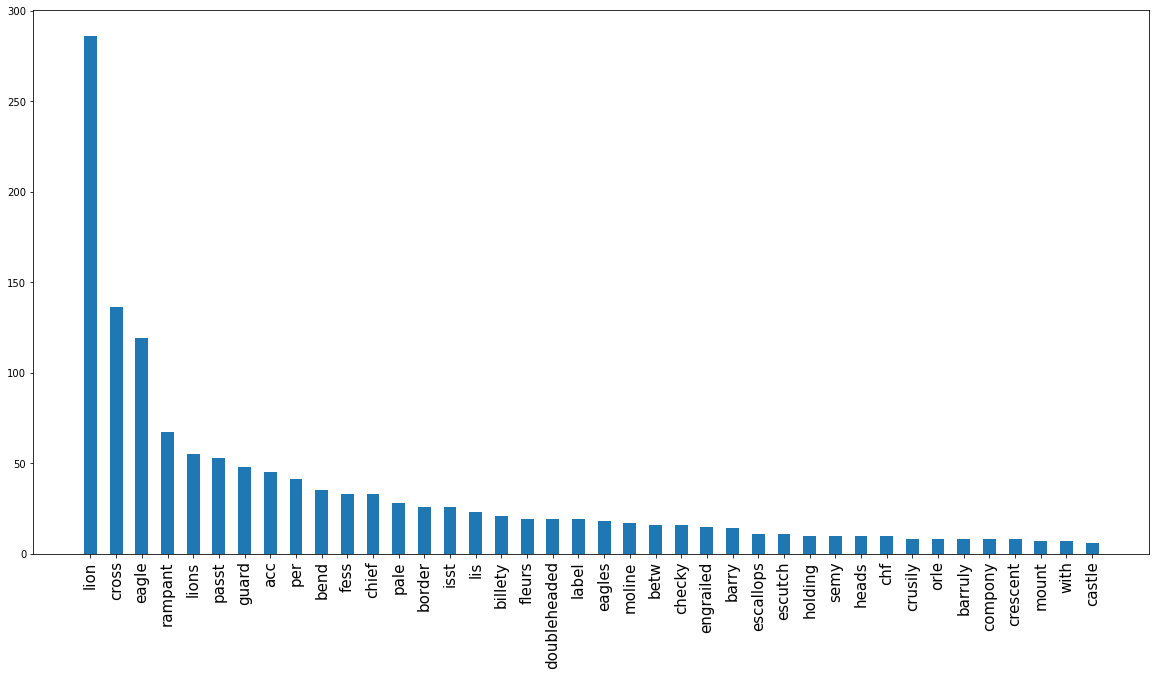

[('lion', 286),
 ('cross', 136),
 ('eagle', 119),
 ('rampant', 67),
 ('lions', 55),
 ('passt', 53),
 ('guard', 48),
 ('acc', 45),
 ('per', 41),
 ('bend', 35),
 ('fess', 33),
 ('chief', 33),
 ('pale', 28),
 ('border', 26),
 ('isst', 26),
 ('lis', 23),
 ('billety', 21),
 ('fleurs', 19),
 ('doubleheaded', 19),
 ('label', 19),
 ('eagles', 18),
 ('moline', 17),
 ('betw', 16),
 ('checky', 16),
 ('engrailed', 15),
 ('barry', 14),
 ('escallops', 11),
 ('escutch', 11),
 ('holding', 10),
 ('semy', 10),
 ('heads', 10),
 ('chf', 10),
 ('crusily', 8),
 ('orle', 8),
 ('barruly', 8),
 ('compony', 8),
 ('crescent', 8),
 ('mount', 7),
 ('with', 7),
 ('castle', 6)]

In [12]:
cleaned_vocabularies_without_color = [l for l in voc if len(l)>2]

y = Counter(cleaned_vocabularies_without_color)
plot_bar_chart(y.most_common(40))
y.most_common(40)

## Check the folder and see. Many images for the same label however they are different. 
## There are wrong labeled data in the ground truth! :( 
It's visible via streamlit tool .. 

## Check if the labels match our simple automata 

In [13]:
captions_val = []
captions_val_armoria = []
for l in labels:
    c = Caption(l, support_plural=False)
    if c.is_valid:
        captions_val.append(l)
    if c.is_valid_in_armoria:
        captions_val_armoria.append(l)

print(f'Total number of valid labels in our automata {len(captions_val)} out of {len(labels)}' )
print(f'Total number of valid labels in our automata and Armoria API {len(captions_val_armoria)} out of {len(labels)}' )

# Total number of valid labels in our automata 907 out of 3065
# Total number of valid labels in our automata and Armoria API 271 out of 3065

# NEW DATA
#Total number of valid labels in our automata 316 out of 582
#Total number of valid labels in our automata and Armoria API 193 out of 582



ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


ValueError (not raised): label " sun on mount; 3 lion passt guard; =; =   {BOS, OS}" cannot be parsed. The chunk "mount;" cannot be fit into any category.
ValueError (not raised): label " sun on mount; 3 lion passt guard; =; =   {BOS, OS}" cannot be parsed. The chunk "guard;" cannot be fit into any category.
ValueError (not raised): label " sun on mount; 3 lion passt guard; =; =   {BOS, OS}" cannot be parsed. The chunk "=;" cannot be fit into any category.
ValueError (not raised): label " sun on mount; 3 lion passt guard; =; =   {BOS, OS}" cannot be parsed. The chunk "=" cannot be fit into any category.
ValueError (not raised): label " sun on mount; 3 lion passt guard; =; =   {BOS, OS}" cannot be parsed. The chunk "{BOS," cannot be fit into any category.
ValueError (not raised): label " sun on mount; 3 lion passt guard; =; =   {BOS, OS}" cannot be parsed. The chunk "OS}" cannot be fit into any category.
No shield color found in this label: " sun on mount; 3 lion passt guard; =; =   {BO

## Check if the labels match our plural automata 

In [14]:
captions_val = []
captions_val_armoria = []
for l in labels:
    c = Caption(l, support_plural=True)
    if c.is_valid:
        captions_val.append(l)
    if c.is_valid_in_armoria:
        captions_val_armoria.append(l)

print(f'Total number of valid labels in our automata {len(captions_val)} out of {len(labels)}' )
print(f'Total number of valid labels in our automata and Armoria API {len(captions_val_armoria)} out of {len(labels)}' )

# Total number of valid labels in our automata 1273 out of 3065
# Total number of valid labels in our automata and Armoria API 271 out of 3065

# NEW DATA
# Total number of valid labels in our automata 382 out of 582
# Total number of valid labels in our automata and Armoria API 193 out of 582


ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


ValueError (not raised): label "S  OG eagle boned trefly" cannot be parsed. The chunk "boned" cannot be fit into any category.
ValueError (not raised): label "S  OG eagle boned trefly" cannot be parsed. The chunk "trefly" cannot be fit into any category.
ValueError (not raised): label " eagle ch. crescent; mounted knight holding scimitar; =; =   {GA, GA}" cannot be parsed. The chunk "crescent;" cannot be fit into any category.
ValueError (not raised): label " eagle ch. crescent; mounted knight holding scimitar; =; =   {GA, GA}" cannot be parsed. The chunk "mounted" cannot be fit into any category.
ValueError (not raised): label " eagle ch. crescent; mounted knight holding scimitar; =; =   {GA, GA}" cannot be parsed. The chunk "knight" cannot be fit into any category.
ValueError (not raised): label " eagle ch. crescent; mounted knight holding scimitar; =; =   {GA, GA}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " eagle ch. cresc

## Double check again via automata directly

In [15]:
automata = LabelCheckerAutomata(support_plural=False)
validated_labels = automata.get_valid_labels(labels)

ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


In [16]:
total = len(labels)
valid = len(validated_labels)
print('Total number of labels', total)
print('Valid labels', valid)
print('Invalid labels', total - valid)

Total number of labels 582
Valid labels 316
Invalid labels 266


In [18]:
captions = [ Caption(l, support_plural=False) for l in labels ]
print(len(captions))


582


In [19]:
valid = [ 1 for c in captions if c.is_valid ]
sum(valid)
# 316

ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


316

# get simple valid labels with lion

In [20]:
simple_automata = LabelCheckerAutomata(support_plural=False)
lion_labels = simple_automata.get_valid_labels_of(labels, 'lion')
print(len(lion_labels))
lion_labels
# 163

ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


['O S lion rampant',
 'O B lion rampant',
 'G O lion passt guard',
 'A SG lion holding trunk',
 'O GS lion cr. & border engrailed',
 "A GV lion and eagle's claw winged sn",
 'A G lion rampant',
 'B A lion rampant',
 'O G lion q.f.',
 'B AG chief ch. lion q.f.',
 'O G lion rampant',
 'A B lion rampant',
 'B X AG lion barruly cr.',
 'B A lion cr.',
 'O B lion rampant',
 'A B lion rampant',
 'O GV lion naissant above mount',
 'B A lion cr.',
 'S OA lion acc. bend',
 'G A lion q.f.',
 'B O lion rampant',
 'E G lion',
 'G O lion guard q.f.',
 'B O lion cr.',
 'G O lion rampant',
 'A GB lion & border engrailed',
 'A G lion cr.',
 'B A lion rampant',
 'G X AS lion checky cr.',
 'B AG lion naissant above mount',
 'G A lion rampant',
 'O X GB lion hooded',
 'A P lion cr.',
 'A G lion rampant',
 'O GO lion guard ch. cross',
 'O B lion cr.',
 'A GO lion stat on mount',
 'G Z lion rampant',
 'A G lion rampant',
 'O GA lion acc. sword per bend',
 'B A lion rampant',
 'B X GA lion barruly cr.',
 'O 

In [21]:
plural_automata = LabelCheckerAutomata(support_plural=True)
lion_labels_p = plural_automata.get_valid_labels_of(labels, 'lion')
print(len(lion_labels_p))
lion_labels_p 
# 208

ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


['O S lion rampant',
 'O B lion rampant',
 'G O lion passt guard',
 'A G 2 lions rampant addorsed',
 'A SG lion holding trunk',
 'O GS lion cr. & border engrailed',
 "A GV lion and eagle's claw winged sn",
 'A G lion rampant',
 'O B 3 lions passt cr.',
 'B A lion rampant',
 'G O 3 lions',
 'O G lion q.f.',
 'B AG chief ch. lion q.f.',
 'O G lion rampant',
 'A B lion rampant',
 'B X AG lion barruly cr.',
 'B A lion cr.',
 'O S 3 lions',
 'O B lion rampant',
 "G OO chevron betw 3 lion's heads",
 'A B lion rampant',
 'O GV lion naissant above mount',
 'B A lion cr.',
 'S OA lion acc. bend',
 'G A lion q.f.',
 'B O lion rampant',
 'E G lion',
 'S O 2 lions passt guard',
 'G O lion guard q.f.',
 'O B 3 lions',
 'B O lion cr.',
 'G O lion rampant',
 'O S 3 lions passt guard',
 'A GB lion & border engrailed',
 'A G lion cr.',
 'B A lion rampant',
 'A XG AB 3 bars compony & lion',
 'G X AS lion checky cr.',
 'B AG lion naissant above mount',
 'O S 3 lions',
 'B A 3 lions cr.',
 'G A lion rampa

# get simple valid labels with cross

In [22]:
cross_labels = plural_automata.get_valid_labels_of(labels, 'cross')


ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


In [23]:
print(len(cross_labels))
cross_labels

94


['G A cross',
 'A G cross patonce',
 'B O cross engrailed',
 'O BB cross patonce acc. 4 martlets',
 'O G cross engrailed',
 'O G cross',
 'B O cross',
 'A G cross',
 'E G cross moline',
 'O SA cross fretty',
 'B OGO cross ch. 5 escallops, crusily',
 'B O cross potenty',
 'O A cross botonny',
 'A G cross engrailed',
 'G AA escutcheon acc. orle of cross crosslets',
 'O G cross fleuretty',
 'G Z cross moline',
 "A S+ cross ch. escutch {Ar boar's head Sa}",
 'B AO cross and crozier sn',
 'A G cross moline',
 'O G cross moline',
 'B AG cross ch. 5 crescents',
 'A X SO cross lozengy',
 'A G 5 lozenges per cross',
 'S A cross patonce',
 'A G cross moline',
 'V A cross',
 'A S cross',
 'O GO lion guard ch. cross',
 'O G cross',
 'B A cross',
 'G EO cross & chief',
 'X G BA per fess & cross couped',
 'G E cross',
 'A B cross',
 'O SA eagle ch. crescent with cross',
 'O X AG cross checky',
 'A B cross moline',
 'O V cross',
 'G A cross potenty',
 'O G cross',
 'G O cross moline',
 'O SS cross ac

# get simple valid labels with eagle

In [24]:
eagle_labels = plural_automata.get_valid_labels_of(labels, 'eagle')


ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


In [25]:
print(len(eagle_labels))
eagle_labels
#93

93


['S A eagle',
 'G O 3 eagles',
 'G O eagle',
 'G AO eagle & border',
 "A GV lion and eagle's claw winged sn",
 'B X AG eagle checky cr.',
 'O GZ eagle & border',
 'A G eagle cr.',
 'G A eagle cr.',
 'B A eagle',
 'G A eagle doubleheaded',
 'B O eagle',
 'A G eagle doubleheaded',
 'B O eagle',
 'S A eagle doubleheaded',
 'O S eagle doubleheaded',
 'O S eagle',
 'A G eagle',
 'A S eagle',
 'B O eagle cr.',
 'A B eagle doubleheaded',
 'G O eagle doubleheaded',
 'G A eagle',
 'O S eagle per fess',
 'A GO eagle ch. crescent',
 'O S 2 eagles in pale',
 'A X BG eagle per pale',
 'V O eagle',
 'G O eagle',
 'A S eagle',
 'O SA eagle ch. crescent',
 'O SA eagle ch. crescent with cross',
 'A SO eagle biting crescent inv.',
 'B A 3 eagles',
 'E G eagle',
 'G A eagle',
 'B O 3 eagles',
 'A BB fess betw 4 eagles',
 'G AS chief ch. eagle isst',
 'O S eagle',
 'A GO eagle cr. boned trefly',
 'A GX AB eagle & border nebuly',
 'B O eagle',
 'O SX AG eagle acc. bend checky',
 'B G eagle',
 'A SG eagle d

In [26]:
elabels = simple_automata.get_valid_labels_of(labels, 'per pale')


ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "lion;" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "maunch" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "fisted" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "holding" cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "annulet," cannot be fit into any category.
ValueError (not raised): label " lion; maunch fisted holding annulet, crusily; =; =  {AS, GAO}" cannot be parsed. The chunk "crusily;" cannot be fit into any category.


In [27]:
print(len(elabels))
elabels

1


['A X BG eagle per pale']